<a href="https://colab.research.google.com/github/mkxdxdxd/CSED499I/blob/main/final_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show javalang
!pip install javalang
import os

#1. Settings

### 1) import required

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/dataset.pkl')

In [ ]:
print(data.columns)

Index(['SubjectID', 'AssignmentID', 'ProblemID', 'CodeStateID', 'Score_x',
       'Code', 'Code-ast', 'code-astnn', 'code-embedding', 'Score_y',
       'embedding', 'astnn', 'prompt', 'prompt-embedding', 'input'],
      dtype='object')


In [ ]:
learning_rate = 1e-4
batch_size = 35
epochs = 800

In [ ]:
data_stu_code = data[['SubjectID', 'prompt-embedding', 'embedding']]
print(data_stu_code)

                              SubjectID  \
0      04c32d4d95425f73b3a1d6502aed4d48   
1      04c32d4d95425f73b3a1d6502aed4d48   
2      04c32d4d95425f73b3a1d6502aed4d48   
3      04c32d4d95425f73b3a1d6502aed4d48   
4      04c32d4d95425f73b3a1d6502aed4d48   
...                                 ...   
39791  ffb72475a81de0e95b910ffad039f5c2   
39792  ffb72475a81de0e95b910ffad039f5c2   
39793  ffb72475a81de0e95b910ffad039f5c2   
39794  ffb72475a81de0e95b910ffad039f5c2   
39795  ffb72475a81de0e95b910ffad039f5c2   

                                        prompt-embedding  \
0      [0.007758622, -0.02058616, 0.051114812, 0.0035...   
1      [0.0004377277, -0.025701463, 0.05109195, 0.003...   
2      [0.0004377277, -0.025701463, 0.05109195, 0.003...   
3      [0.019149723, -0.0023263248, 0.052457552, 0.01...   
4      [0.019149723, -0.0023263248, 0.052457552, 0.01...   
...                                                  ...   
39791  [-0.010156284, -0.011037813, 0.0460355, 0.0212...   
397

In [ ]:
grouped = data_stu_code.groupby('SubjectID')

In [ ]:
students_data ={}
for subject_id, group in grouped:
    #print(group['prompt-embedding'])
    embeddings = group['prompt-embedding'].tolist()  # Converting string representations of lists back to lists
    labels = group['embedding'].tolist()

    embeddings = np.array(embeddings, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    students_data[subject_id] = (embeddings, labels)

# Neural Network

In [ ]:
#build neural network
class NeuralNetwork(nn.Module):
  def __init__(self):
     super().__init__()
     self.linear_relu_stack = nn.Sequential(
        nn.Linear(768, 600),
        nn.ReLU(),
        nn.Linear(600, 400),
        nn.ReLU(),
        nn.Linear(400, 200)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
val_loss_history = {}
train_loss_history = {}
test_loss_history = {}
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # prediction and loss calculation
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if student_id not in train_loss_history:
              train_loss_history[student_id] = []
            train_loss_history[student_id].append(loss)
            print(f"Train loss: {loss:>8f}")


def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item() #calculate val loss

    val_loss /= num_batches
    if student_id not in val_loss_history:
      val_loss_history[student_id] = []
    val_loss_history[student_id].append(val_loss)
    print(f"val loss: {val_loss:>8f} ")

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in dataloader:
          pred = model(X)
          test_loss += loss_fn(pred, y).item() #calculate val loss

  test_loss /= num_batches
  if student_id not in test_loss_history:
      test_loss_history[student_id] = []
  test_loss_history[student_id].append(test_loss)
  print(f"test loss: {test_loss:>8f} \n")

In [ ]:
#initialize
model = {}
test_loss_early_stopping = {}

for student_id, _ in students_data.items():
  one_student = students_data[student_id]
  X = torch.tensor(one_student[0])
  y = torch.tensor(one_student[1])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #training:test = 8:2
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2, shuffle=False) #training:valid = 8:2 again

  train_dataset = TensorDataset(X_train, y_train)
  val_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  dataloaders = {}
  dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  device = torch.device("cpu")
  model[student_id] = NeuralNetwork().to(device)
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model[student_id].parameters(), lr=learning_rate)

  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      print(f"Student id: {student_id}")
      train_loop(dataloaders['train'], model[student_id], loss_func, optimizer)
      val_loop(dataloaders['val'], model[student_id], loss_func)
      test_loop(dataloaders['test'], model[student_id], loss_func)
  print("Done!")

  index_min = min(range(len(val_loss_history[student_id])), key=val_loss_history[student_id].__getitem__)
  # print("Minimum for validation set")
  # print("epoch: ", index_min+1, "value: ", min(val_loss_history[student_id]))
  # print("test loss: ", test_loss_history[student_id][index_min]) #test loss for such epoch
  test_loss_early_stopping[student_id] = test_loss_history[student_id][index_min]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 87
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.095988
val loss: 0.075895 
test loss: 0.085229 

Epoch 88
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.095753
val loss: 0.075899 
test loss: 0.085265 

Epoch 89
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.095508
val loss: 0.075907 
test loss: 0.085319 

Epoch 90
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.095236
val loss: 0.075917 
test loss: 0.085385 

Epoch 91
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.094944
val loss: 0.075925 
test loss: 0.085438 

Epoch 92
-------------------------------
Student id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.094659
val loss: 0.075932 
test loss: 0.085481 

Epoch 93
-------------------------------
Student id: ffb72475a81de0e9

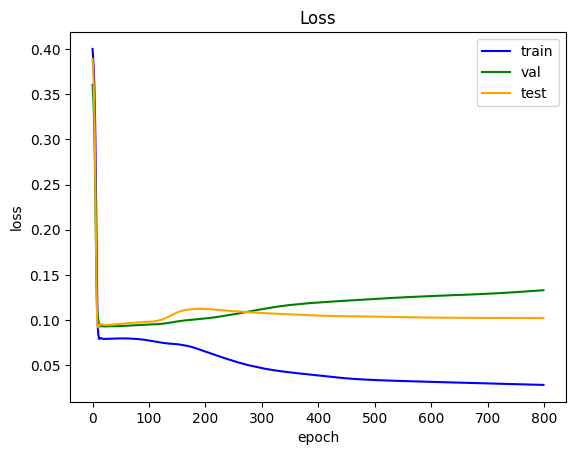

{'04c32d4d95425f73b3a1d6502aed4d48': 0.09469025830427806, '0503bf609757acf2e75aa8cbc0d8323b': 0.09769883006811142, '06d801cb636235b298c40029ad9921e7': 0.11146798729896545, '07ae4cca3f90a49347ccb5c1a82ff46f': 0.10465974360704422, '07d34e2419c61216a85a2156b2cf8ae4': 0.08358840644359589, '08fcb5ead4e963a6f0bbdbc971f4a3ee': 0.08981403335928917, '0a7ff96e4fa7c92a13ccab013d580930': 0.12753237783908844, '0aaf61723a352ba7ea1be4502df85765': 0.10896123573184013, '0ae12dc3676bc09a35fe6ed96926a6b5': 0.09649169445037842, '0bbeaf0242180c8abffb2b8dada5a9e4': 0.07190993428230286, '0e2cb039638d9ab503d33105ed343d7e': 0.08603273332118988, '0ee7e71061cf860ccf3b29c6823c7971': 0.08781560137867928, '115c51eb37365df2d4f4e2482b964822': 0.09410461783409119, '11d8ffa1c1cb79e22b6d94667d3847d9': 0.10075701400637627, '1379719828be9ee6b08ca64edb818e2b': 0.11231125518679619, '138a14eaf4a8c188a6c41cafd9400a30': 0.10299824923276901, '13dfe127c6d40641c7ad9fd60ef8701d': 0.09172295033931732, '14b094aef5d2df47fa9dd009b2d6e

In [ ]:
#Let's draw a learning curve like below.
student_id = "04c32d4d95425f73b3a1d6502aed4d48"
plt.plot(train_loss_history[student_id], label='train', color='blue')
plt.plot(val_loss_history[student_id], label='val', color='green')
plt.plot(test_loss_history[student_id], label='test', color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

# index_min = min(range(len(val_loss_history)), key=val_loss_history.__getitem__)
# print("Minimum for validation set")
# print("epoch: ", index_min+1, "value: ", min(val_loss_history))
# print("test loss: ", test_loss_history[index_min]) #test loss for such epoch

print(test_loss_early_stopping)

In [ ]:
nn_test_loss = pd.DataFrame(list(test_loss_early_stopping.items()), columns=['SubjectID', 'Test loss'])

from google.colab import files
nn_test_loss.to_csv('nn_test_loss.csv')
files.download('nn_test_loss.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>